# Семинар 7: градиентный спуск

## Вступление

В этом семинаре мы будем говорить про градиентный спуск. Это алгоритм оптимизации, т.е. численный метод поиска локального минимума/максимума) функции. Достигается такой эффект с помощью движения вдоль вектора градиента (в сторону антиградиента для поиска минимума, в противоположную сторону -- для поиска максимума). Градиент это собственно по определению вектор, своим направлением указывающий направление наискорейшего роста, в нашем случае, функции.
Градиентный спуск, как можно догадаться, учитывая вышесказанное, актуален для огромного количества задач машинного обучения, начиная от классического и углубляясь в сторону глубокого обучения. Он имеет смысл даже в самом простом виде, однако со временем было придумано огромное количество его вариаций, более выгодных для определённых задач.

### План семинара

1. Введение
    * Лёгкое погружение в тему линейной алгебры (маленькое путешествие в трехмерную геометрию)
    * Создание и визуализация функций
2. Познаём суть
    * Разбираемся с вычислением градиента
    * Применяем наши новые способности на практике, вычисляя градиент для конкретных функций
    * Реализуем и применяем градиентный спуск, смотрим на картинки
    * Применяем градиентный спуск для линейной регрессии
    * Подробнее визуализируем градиентный спуск
3. Двигаемся дальше
    * Знакомимся с вариациями градиентного спуска
    * Ещё больше визуализаций!
    * Сравниваем подходы
    * Прикладной бонус на будущее



## 1. Введение

### Маленькое путешествие в трехмерную геометрию

#### Теоретическая часть

##### Ответьте на вопросы:
*  Каким уравнением задается прямая на плоскости? Чем отличаются записи $y = kx + b$ и $ax + by + c = 0$?

* Запишите уравнение плоскости в трехмерном пространстве, уравнение гиперплоскости в многомерном пространстве. Используя введенные обозначения, ответьте, в пространстве какой размерности задается гиперплоскость из предыдущего вопроса?

* Если какой-то из коэффициентов в уравнении гиперплоскости равен 0, что это геометрически означает?

* Что означает, что свободный член равен 0?

### Часть с картинками: визуализация функции от двух переменных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

Ниже дана функция, визуализирующая поверхности. Ознакомьтесь с ее интерфейсом.

In [2]:
def plot_3d(fun, a=-1, b=1, c=-1, d=1, trace=None):
    """
    Визуализирует функцию fun на квадрате [a, b] x [c, d]
    fun : функция, принимающая два аргумента
         (np.array одинакового размера) и возвращающая
          np.array того же размера со значениями функции
          в соответствующих точках
    Дополнительно можно нарисовать ломаную линию из N точек,
    лежащую на получившейся поверхности
    trace : np.array размера N x 2 - координаты на плоскости,
            обозначающие точки ломаной
    """
    fig = plt.figure(figsize=(10, 8))

    # Make grid
    x1_ = np.linspace(a, b, 100)
    x2_ = np.linspace(c, d, 100)
    x1, x2 = np.meshgrid(x1_, x2_)
    y = fun(x1, x2)

    # Plot the surface
    ax = fig.add_subplot(1, 1, 1, projection="3d")
    ax.plot_surface(x1, x2, y, alpha=0.6)
    ax.contour(x1, x2, y, zdir="z", offset=y.min(), cmap=cm.coolwarm)

    # Plot 3d line
    if trace is not None:
        y_trace = fun(trace[:, 0], trace[:, 1])
        ax.plot(trace[:, 0], trace[:, 1], y_trace, "o-")
        ax.set_xlim(x1.min(), x1.max())
        ax.set_ylim(x2.min(), x2.max())
        ax.set_zlim(y.min(), y.max())



Нарисуем с ее помощью параболоид:

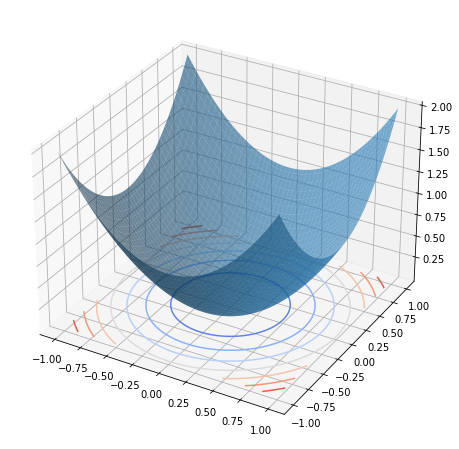

In [3]:
fun = lambda x1, x2: x1**2 + x2**2
plot_3d(fun)

Круги на плоскости показывают проекции линий уровня параболоида.

**Задание**: нарисуйте плоскость $y = x_1 + 2 x_2 + 3$:

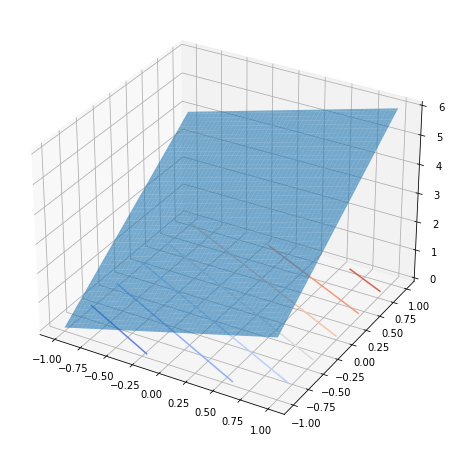

In [5]:
fun = lambda x1, x2: x1 + 2 * x2 + 3
plot_3d(fun)
# a1x1 + a2x2 + a3x3 + b = 0

**Задание**: нарисуйте плоскость, параллельную любой из горизонтальных осей:

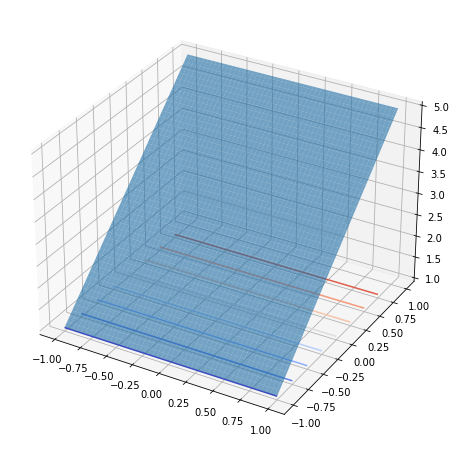

In [6]:
fun = lambda x1, x2: 2 * x2 + 3
plot_3d(fun)

**Задание**: нарисуйте плоскость, проходящую через начало координат:

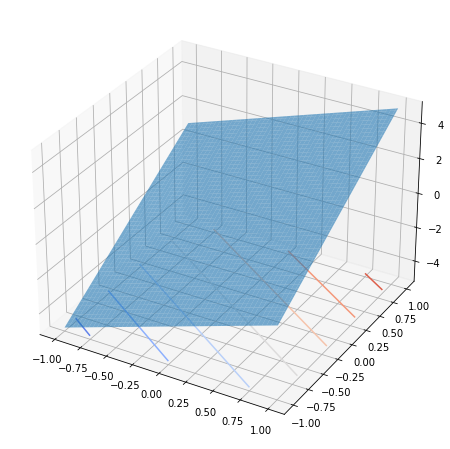

In [7]:
fun = lambda x1, x2: 2 * x1 + 3 * x2
plot_3d(fun)

## 2. Познаём суть

### Градиентный спуск, теоретическая часть

Градиент функции $f(x) = f(x_1, \dots, x_d)$ от многих переменных в точке $x_0$ - это вектор ее частных производных, вычисленных в точке $x_0$.
$$\nabla_x f \bigl | _{x_0} = \biggl(\frac{\partial f}{\partial x_1}, \dots, \frac{\partial f}{\partial x_d} \biggr ) \biggl | _{x_0}$$

Разберем два простых примера вычисления градиента в случае функции от двух переменных.

#### Задача 1

Найдите градиент линейной функции $f(x) = f(x_1, x_2) = c_1 x_1 + c_2 x_2$ ($c_1$ и $c_2$ - фиксированные числа). 

__Решение.__

Найдем первую частную производную: 

$$\frac{\partial f}{\partial x_1} = \frac{\partial (c_1 x_1 + c_2 x_2)}{\partial x_1} = c_1.$$

Значит, первая компонента градиента равна $c_1$. Аналогично со второй компонентой. 

Ответ:

$$\nabla_x f = (c_1, c_2)$$

Можно подставить конкретные коэффициенты, например $c_1 = 3$ и $c_2 = 7$. Тогда градиент будет равен $(3, 7)$. 

#### Задача 2
Найдите градиент квадратичной функции $f(x) = f(x_1, x_2) = c_1 x_1^2 + c_2 x_2^2$ ($c_1$ и $c_2$ - фиксированные числа). 

__Решение.__
Найдем первую частную производную: 

$$\frac{\partial f}{\partial x_1} = \frac{\partial (c_1 x_1^2 + c_2 x_2^2)}{\partial x_1} = 2 c_1 x_1.$$

Значит, первая компонента градиента равна $2 c_1 x_1$. Аналогично со второй компонентой. 

Ответ:

$$\nabla_x f = (2 c_1 x_1, 2 c_2 x_2)$$

При неотрицательных $c_1, c_2$ минимум такой квадратичной функции достигается в 0.
Наша следующая цель - найти этот минимум с помощью градиентного спуска. 

__Вспомните из лекции:__
* Какую (оптимизационную) задачу решает градиентный спуск?
* Как работает алгоритм градиентного спуска?
* Как выбирать начальную инициализацию в градиентном спуске?
* Когда останавливать градиентный спуск?

### Градиент квадратичной функции

Воспользуемся кодом для вычисления квадратичной функции  и обобщим ее на случай произвольных коэффициентов:

In [8]:
def fun(x1, x2, c1=1, c2=1):
    return c1 * (x1**2) + c2 * (x2**2)

Эта функция способна обрабатывать x1 и x2 любой размерности, но градиенты будем считать в предположении, что x1 и x2 - числа (так проще)

Теперь надо реализовать подсчет градиента функции fun. Напишите код функции вычисления градиента в одной точке согласно описанию:

In [12]:
def grad_fun(x1, x2, c1=1, c2=1):
    """
    Функция берет 2 числа, обозначающую точку, в которой вычисляется градиент,
    и возвращает np.array размера (2,) - градиент квадратичной функции
    Опциональные аргументы: c1 и c2 - коэффициенты
    """
    return np.array([2 * x1 * c1, 2 * x2 * c2])

Проверьте правильность (сверьте с формулой):

In [13]:
grad_fun(x1=0.5, x2=1.5, c1=2, c2=3)

array([2., 9.])

### Градиентный спуск

Теперь реализуем градиентный спуск. 
Он работает следующим образом: 
1. сначала инициализируется начальная точка x 
1. затем повторяются итерации:
$$x^{(t)} = x^{(t-1)} - \alpha \nabla_{x^{(t-1)}} f$$
Здесь $\alpha$ - длина шага.

Допишите функцию согласно описанию:

In [16]:
from copy import deepcopy

In [17]:
def grad_descend(grad_fun, step_size=0.1, num_steps=50):
    """
    Реализует градиентный спуск
    Аргументы:
    * grad_fun - функция, вычисляющая градиент
    * step_size - длина шага
    * num_steps - число итераций

    Возвращает np.array размера (num_steps+1) x 2,
    (i+1)-й элемент - точка на (i+1)-й итеарации,
    нулевой элемент - случайная инициализация
    """
    x = np.array([np.random.rand(2)])
    trace = deepcopy(x)
    for _ in range(num_steps):
      x -= grad_fun(x[0][0], x[0][1]) * step_size
      trace = np.concatenate((trace, x), axis=0)
    return trace

Протестируем функцию (последний элемент должен быть близок к 0):

In [ ]:
np.random.seed(16)

trace = grad_descend(grad_fun)
trace

Теперь мы готовы визуализировать градиентный спуск. Для этого передадим нашу траекторию оптимизации в качестве последнего аргумента функции plot_3d.

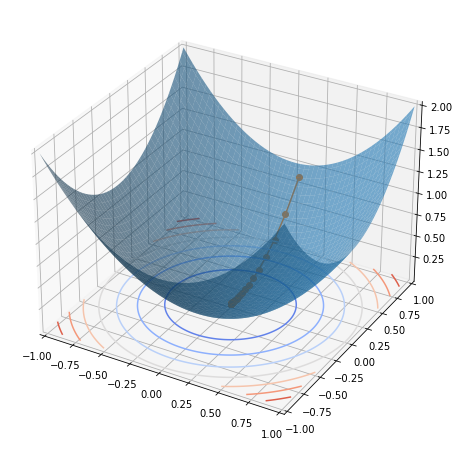

In [23]:
trace = grad_descend(grad_fun, 0.1, 30)
plot_3d(fun, trace=trace)

Запустите оптимизацию несколько раз, чтобы посмотреть, как ведет себя процесс при различных случайных начальных приближениях:

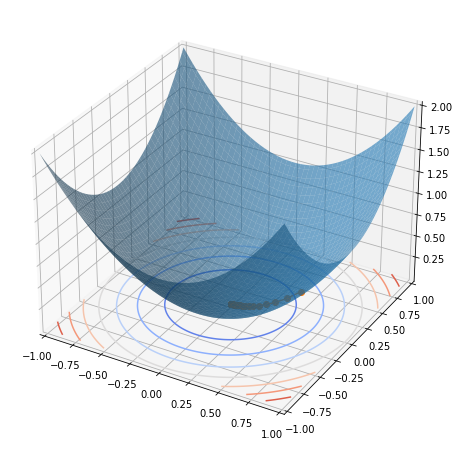

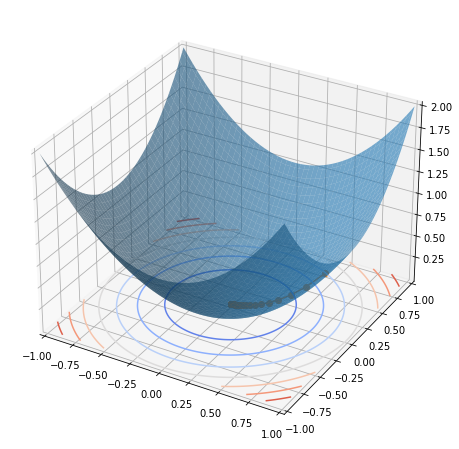

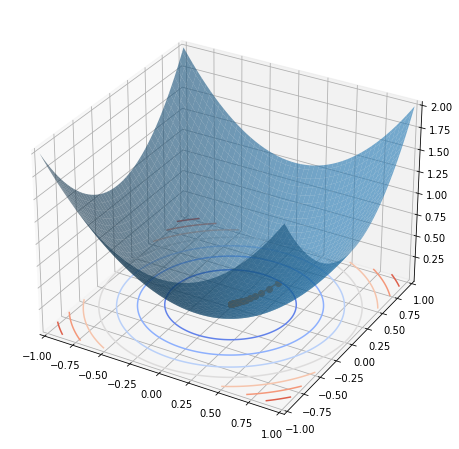

In [24]:
for i in range(3):
    trace = grad_descend(grad_fun, 0.1, 30)
    plot_3d(fun, trace=trace)

Попробуйте разную длину шага из множества $(0.01, 0.1, 0.5, 1)$.

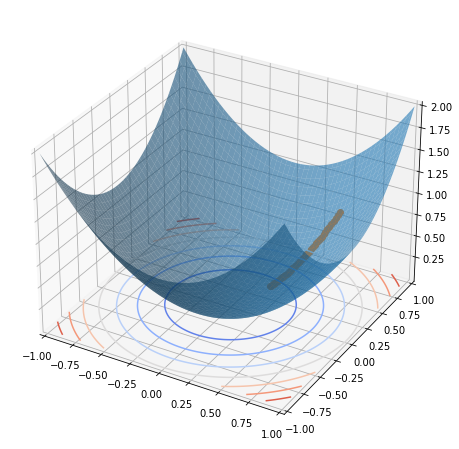

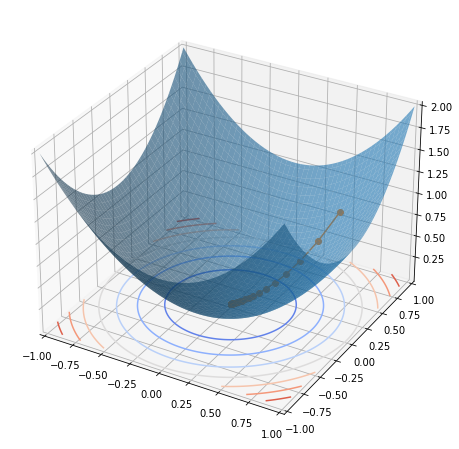

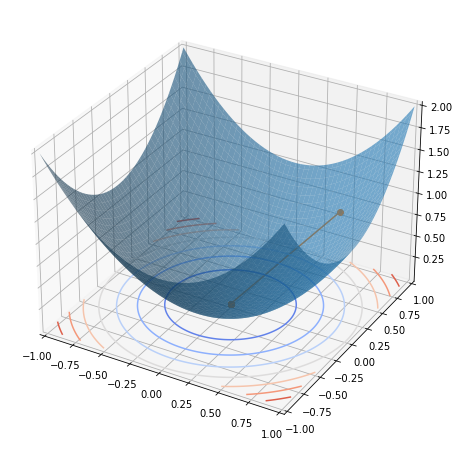

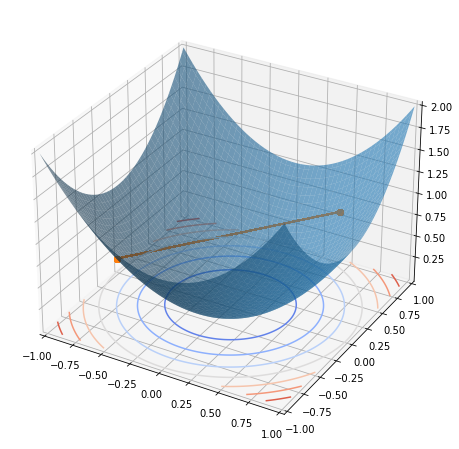

In [25]:
for ss in [0.01, 0.1, 0.5, 1]:
    np.random.seed(0)
    trace = grad_descend(grad_fun, step_size=ss)
    plot_3d(fun, trace=trace)

При маленькой длине шага процесс идет сишком медленно, при большой - может разойтись.

Наконец, попробуем использовать другие коэффициенты. 
Оптимизируем функцию $f(x) = x_1^2 + 5 x_2^2$, пробуя длину шага (0.1, 0.2, 0.5):

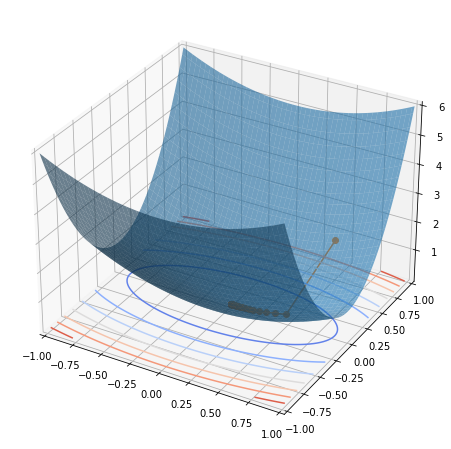

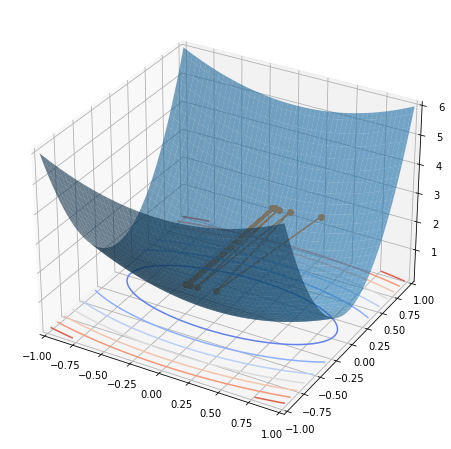

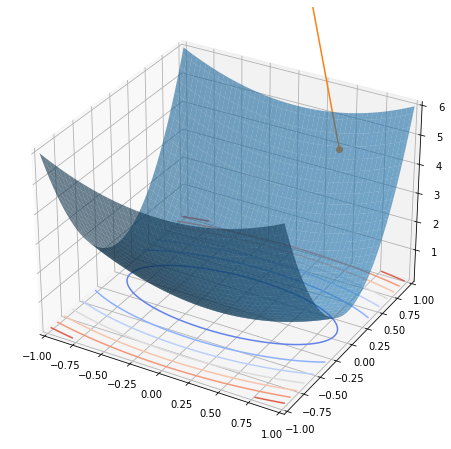

In [26]:
fun_c = lambda x1, x2: fun(x1, x2, 1, 5)
grad_fun_c = lambda x1, x2: grad_fun(x1, x2, 1, 5)

for ss in [0.1, 0.2, 0.5]:
    trace = grad_descend(grad_fun_c, step_size=ss)
    plot_3d(fun_c, trace=trace)

"Вытянутую" функцию сложнее оптимизировать. Именно поэтому данные рекомендуется нормировать перед обучением модели, чтобы избежать таких колебаний при оптимизации.

###  Градиентый спуск для оценки параметров линейной регрессии 
На простом примере разберём основные тонкости, связанные со стохастической оптимизацией.

Сгенерируем матрицу объекты-признаки $X$ и вектор весов $w_{true}$, вектор целевых переменных $y$ будем вычислять как:

$$
y = Xw_{true} + \epsilon,
$$
где $\epsilon \sim N(0, 1)$ (нормальный шум).

In [27]:
np.random.seed(25)

In [28]:
n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
Y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_0 = np.random.uniform(-2, 2, (n_features))

Если мы попробуем ручками минимизировать MSE, то оптимальный набор параметров будет выглядеть так: $w = (X^TX)^{-1}X^Ty$. В этой формуле присутствует обращение матрицы $X^TX$ — очень трудоёмкая операция при большом количестве признаков. Сложность вычислений в этом случае равна $O(d^3 + d^2 \ell)$, где $l$ - число объектов, $d$ — число признаков. При решении задач такая трудоёмкость часто оказывается непозволительной, поэтому параметры ищут итерационными методами, стоимость которых меньше. Один из них — градиентный спуск.

Вспомним, что в градиентном спуске значения параметров на следующем шаге получаются из значений параметров на текущем шаге смещением в сторону антиградиента функционала $Q(w)$: 

$$w^{(t+1)} = w^{(t)} - \eta_t \nabla Q(w^{(t)}),$$
где $\eta_t$ — длина шага градиентного спуска.

Также вспомним, что функционал MSE в матричном виде можно записать так:
$$
Q(w) = (y - Xw)^T(y-Xw)
$$
А соответствующий градиент:
$$
\nabla_w Q(w) = \nabla_w[y^Ty - y^TXw - w^TX^Ty + w^TX^TXw] = 0 - X^Ty - X^Ty + (X^TX + X^TX)w = 2X^T(Xw-y)
$$
 

Сложность вычислений при нахождении параметров в данном случае равна $O(d \ell)$. 

Обучим на полученных данных линейную регрессию для MSE при помощи полного градиентного спуска.
В результате, получим вектор оценок параметров

In [29]:
w = w_0.copy()
w_list = [w.copy()]
step_size = 1e-2

for i in range(num_steps):
    w -= 2 * step_size * np.dot(X.T, np.dot(X, w) - Y) / Y.shape[0]
    w_list.append(w.copy())
w_list = np.array(w_list)

### Визуализация траекторий GD

Покажем последовательность оценок параметров $w^{(t)}$, получаемых в ходе итераций. Красная точка — $w_{true}$.

Для этого напишем функцию, которую будем и дальше использовать для визуализации процесса оптимизации.

In [30]:
def plot_gradient(w_list, title):
    A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))

    plt.figure(figsize=(15, 6))
    plt.title(title)
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim((w_list[:, 0].min() - 0.2, w_list[:, 0].max() + 0.2))
    plt.ylim((w_list[:, 1].min() - 0.2, w_list[:, 1].max() + 0.2))
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_true[0], w_true[1], c="r")
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

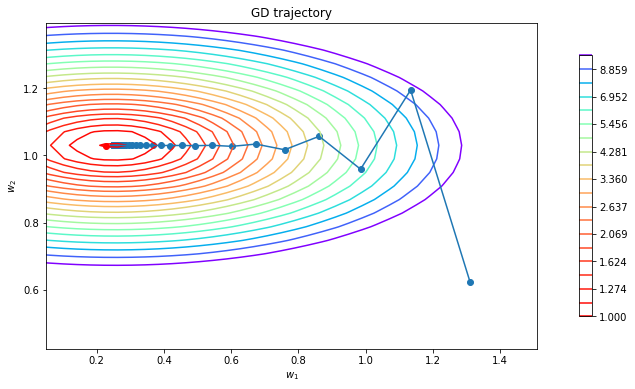

In [31]:
plot_gradient(w_list, "GD trajectory")

На лекции обсуждалось, что градиент перпендикулярен линиям уровня. Это объясняет такие зигзагообразные траектории градиентного спуска. Для большей наглядности в каждой точке пространства посчитаем градиент функционала и покажем его направление.

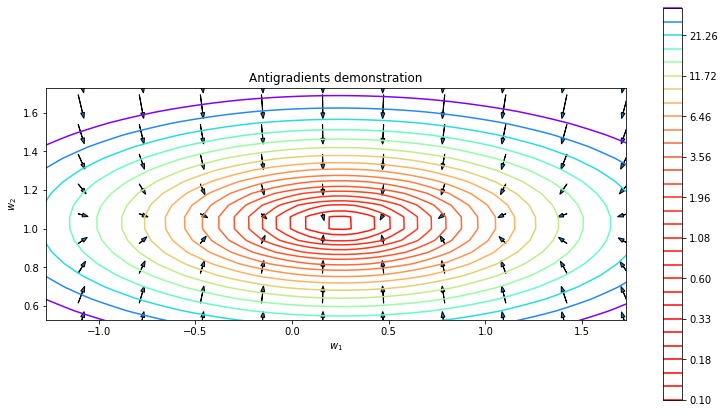

In [33]:
# compute level set
A, B = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
A_mini, B_mini = np.meshgrid(np.linspace(-3, 3, 20), np.linspace(-2, 2, 27))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))

# visualize the level set
plt.figure(figsize=(13, 9))
CS = plt.contour(
    A, B, levels, levels=np.logspace(-1, 1.5, num=30), cmap=plt.cm.rainbow_r
)
CB = plt.colorbar(CS, shrink=0.8, extend="both")

# visualize the gradients
gradients = np.empty_like(A_mini)
for i in range(A_mini.shape[0]):
    for j in range(A_mini.shape[1]):
        w_tmp = np.array([A_mini[i, j], B_mini[i, j]])
        antigrad = -2 * 1e-3 * np.dot(X.T, np.dot(X, w_tmp) - Y) / Y.shape[0]
        plt.arrow(A_mini[i, j], B_mini[i, j], antigrad[0], antigrad[1], head_width=0.02)

plt.title("Antigradients demonstration")
plt.xlabel(r"$w_1$")
plt.ylabel(r"$w_2$")
plt.xlim((w_true[0] - 1.5, w_true[0] + 1.5))
plt.ylim((w_true[1] - 0.5, w_true[1] + 0.7))
plt.gca().set_aspect("equal")
plt.show()

## 3. Двигаемся дальше

### Стохастический градиентый спуск
Существуют различные модификации градиентного спуска. 
Мы познакомимся с одной из них — стохастическим градиентным спуском.
От варианта выше он отличается заменой градиента на несмещённую оценку градиента по одному или нескольким объектам. В этом случае сложность становится $O(kd)$, где $k$ — количество объектов, по которым оценивается градиент, $k \ll \ell$. Для больших массивов данных стохастический градиентный спуск может дать значительное преимущество в скорости по сравнению со стандартным градиентным спуском.

#### Применяем

Давайте теперь модифицируем код и будем считать градиент не по всему набору данных, а только по случайной подвыборке объектов. Получим траектории стохастического градиентного спуска.

Генерацию выборки и подсчет градиента оформим в виде функции.

In [34]:
def calc_grad_on_batch(X, Y, w, batch_size):
    sample = np.random.randint(n_objects, size=batch_size)
    return 2 * np.dot(X[sample].T, np.dot(X[sample], w) - Y[sample]) / batch_size

In [35]:
step_size = 1e-2

w = w_0.copy()
w_list = [w.copy()]

for i in range(num_steps):
    w -= step_size * calc_grad_on_batch(X, Y, w, batch_size)
    w_list.append(w.copy())

w_list = np.array(w_list)

 ### Визуализация траекторий SGD

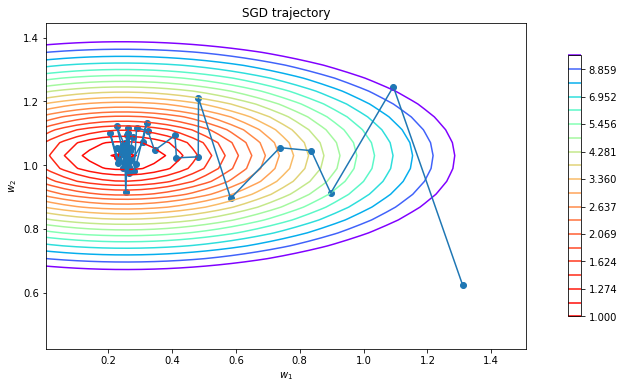

In [36]:
plot_gradient(w_list, "SGD trajectory")

Как видно, метод стохастического градиента «бродит» вокруг оптимума. На такое поведение можно повлиять подбором шага градиентного спуска $\eta_t$. 

### Давайте ещё больше экспериментировать с градиентным спуском!

Попробуем уменьшать шаг градиентного спуска на каждой итерации.

In [37]:
step_size_0 = 0.01

w = w_0.copy()
w_list = [w.copy()]


for i in range(num_steps):
    step_size = step_size_0 / (i + 1)
    w -= step_size * calc_grad_on_batch(X, Y, w, batch_size)
    w_list.append(w.copy())

w_list = np.array(w_list)

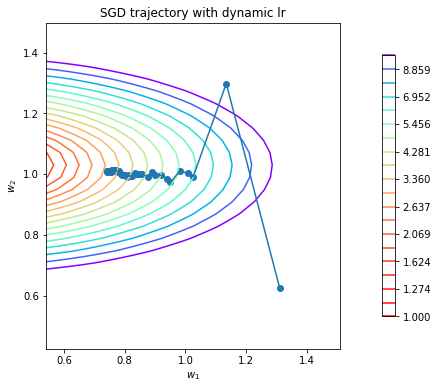

In [38]:
plot_gradient(w_list, "SGD trajectory with dynamic lr")

Теперь градиентный спуск движется более направленно, но не доходит до оптимума. Попробуем более сложную схему изменения длины шага:
$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p.
$$
Возьмем $s_0 = 1$ и поэкспериментируем с разными $\lambda$ и $p$.

In [39]:
def sgd_with_lr_schedule(lambda_param, p=0.5, s_init=1.0, batch_size=10):
    w = w_0.copy()
    w_list = [w.copy()]

    for i in range(num_steps):
        step_size = lambda_param * np.power(s_init / (s_init + i), p)
        w -= step_size * calc_grad_on_batch(X, Y, w, batch_size)
        w_list.append(w.copy())

    return np.array(w_list)

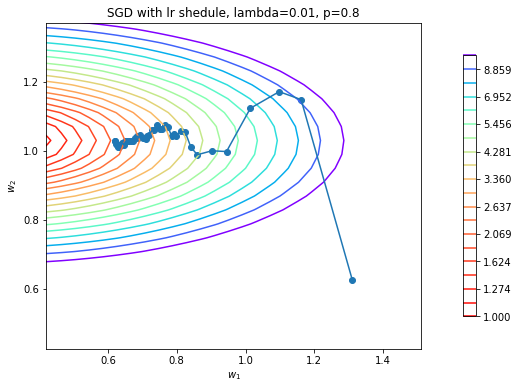

In [41]:
w_list = sgd_with_lr_schedule(lambda_param=0.01, p=0.8)
plot_gradient(w_list, f"SGD with lr shedule, lambda={0.01}, p={0.8}")

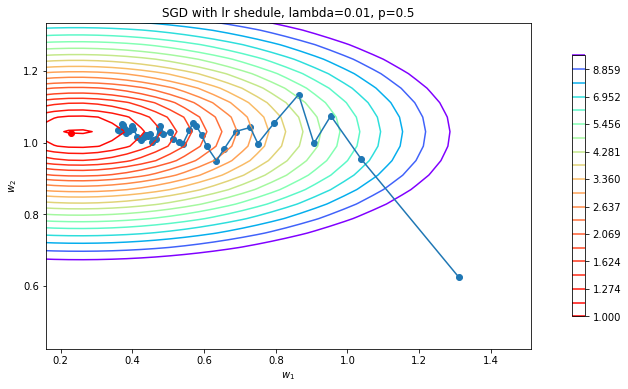

In [46]:
w_list = sgd_with_lr_schedule(lambda_param=0.01, p=0.5)
plot_gradient(w_list, f"SGD with lr shedule, lambda={0.01}, p={0.5}")

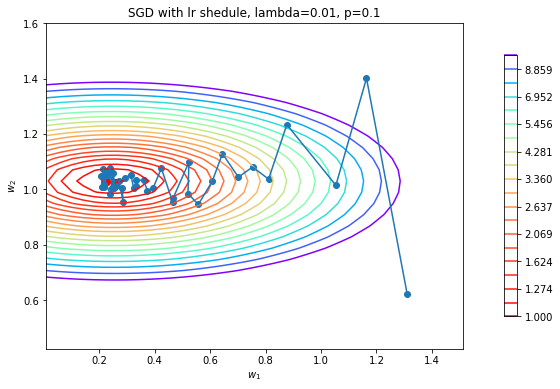

In [47]:
w_list = sgd_with_lr_schedule(lambda_param=0.01, p=0.1)
plot_gradient(w_list, f"SGD with lr shedule, lambda={0.01}, p={0.1}")

Коэффициенты в формуле для длины шага являются гиперпараметрами, и их нужно подбирать. Желательно использовать для этого валидационную выборку.

Теперь посмотрим, как размер подвыборки, по которой оценивается градиент, влияет на сходимость.

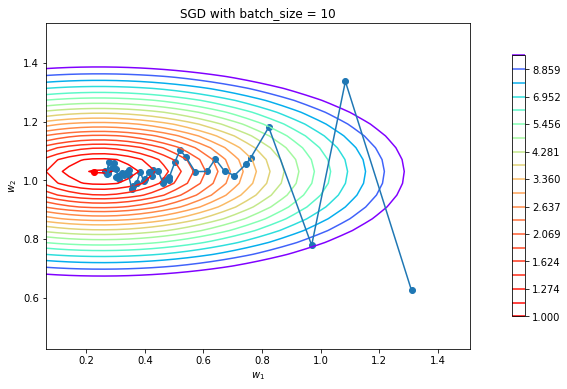

In [48]:
w_list = sgd_with_lr_schedule(lambda_param=0.01, p=0.35, batch_size=10)
plot_gradient(w_list, f"SGD with batch_size = {10}")

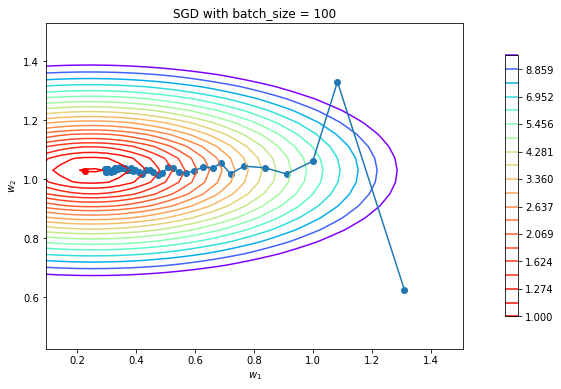

In [ ]:
w_list = sgd_with_lr_schedule(lambda_param=0.01, p=0.35, batch_size=100)
plot_gradient(w_list, f"SGD with batch_size = {100}")

Вывод, в общем-то, очевидный: чем больше размер подвыборки, тем более стабильная траектория градиентного спуска.

### Сравнение скоростей сходимости

Теперь посмотрим, насколько быстро достигают оптимума методы полного и стохастического градиентного спуска. Сгенерируем выборку и построим два графика: 
 - зависимость значения лосса от номера итерации градиентного спуска;
 - зависимость нормы градиента функции потерь от номера итерации градиентного спуска.


 Норма градиента функции потерь вычисляется по формуле:

 $$
||\nabla Q(w)|| = ||2𝑋^𝑇(𝑋𝑤−𝑦)||
 $$

In [49]:
# снова нарандомим данные
n_features = 50
n_objects = 1000
num_steps = 200
batch_size = 10

w_true = np.random.uniform(-2, 2, n_features)

X = np.random.uniform(-10, 10, (n_objects, n_features))
Y = X.dot(w_true) + np.random.normal(0, 5, n_objects)

In [50]:
from scipy.linalg import norm

step_size_sgd = 1e-2
step_size_gd = 1e-2
w_sgd = np.random.uniform(-4, 4, n_features)
w_gd = w_sgd.copy()
residuals_sgd = [np.mean(np.power(np.dot(X, w_sgd) - Y, 2))]
residuals_gd = [np.mean(np.power(np.dot(X, w_gd) - Y, 2))]

norm_sgd = []
norm_gd = []


for i in range(num_steps):
    step_size = step_size_sgd / ((i + 1) ** 0.51)
    sample = np.random.randint(n_objects, size=batch_size)

    w_sgd -= (
        2
        * step_size
        * np.dot(X[sample].T, np.dot(X[sample], w_sgd) - Y[sample])
        / batch_size
    )
    residuals_sgd.append(np.mean(np.power(np.dot(X, w_sgd) - Y, 2)))
    norm_sgd.append(norm(np.dot(X[sample].T, np.dot(X[sample], w_sgd) - Y[sample])))

    w_gd -= 2 * step_size_gd * np.dot(X.T, np.dot(X, w_gd) - Y) / Y.shape[0]
    residuals_gd.append(np.mean(np.power(np.dot(X, w_gd) - Y, 2)))
    norm_gd.append(norm(np.dot(X.T, np.dot(X, w_gd) - Y)))

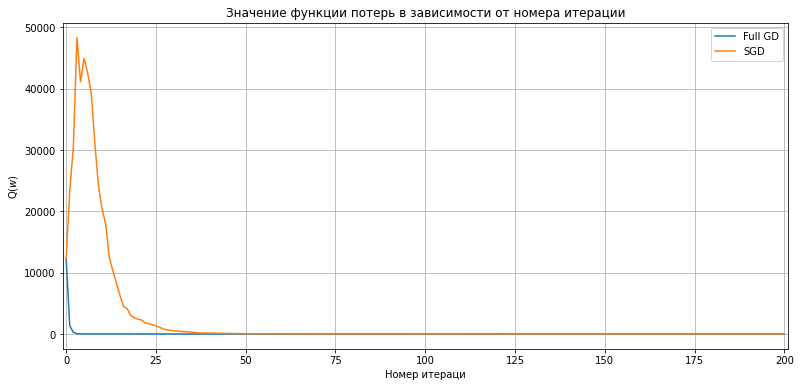

In [51]:
plt.figure(figsize=(13, 6))
plt.plot(range(num_steps + 1), residuals_gd, label="Full GD")
plt.plot(range(num_steps + 1), residuals_sgd, label="SGD")

plt.title("Значение функции потерь в зависимости от номера итерации")
plt.xlim((-1, num_steps + 1))
plt.legend()
plt.xlabel("Номер итераци")
plt.ylabel(r"Q($w$)")
plt.grid()
plt.show()

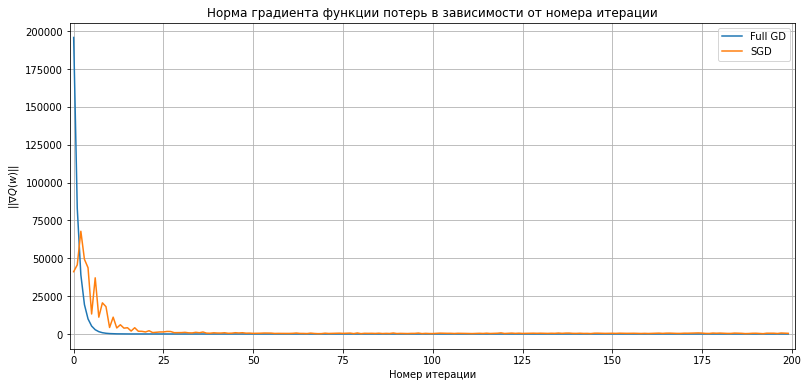

In [52]:
plt.figure(figsize=(13, 6))
plt.plot(range(num_steps), norm_gd, label="Full GD")
plt.plot(range(num_steps), norm_sgd, label="SGD")

plt.title("Норма градиента функции потерь в зависимости от номера итерации")
plt.xlim((-1, num_steps + 1))
plt.legend()
plt.xlabel("Номер итерации")
plt.ylabel(r"$||\nabla Q$($w$)||")
plt.grid()
plt.show()

Как видно, GD буквально за несколько итераций оказывается вблизи оптимума, в то время как поведение SGD может быть весьма нестабильным. Нестабильное поведение стохастической модификации на начальных итерациях хорошо заметно на графике с нормой градиента. Как правило, для более сложных моделей наблюдаются ещё большие колебания. Путём подбора величины шага можно добиться лучшей скорости сходимости, и существуют методы, адаптивно подбирающие величину шага (например, AdaGrad, Adam, RMSProp).

### Бонус

Как видите, градиентный спуск -- очень мощный инструмент для решения задач машинного обучения. Возможно, это наиболее широко применимый в этой области алгоритм. Есть широко известная и обновляемая статья, в которой собраны наиболее актуальные модификации алгоритма градиентного спуска. Рекомендуем для изучения: https://www.ruder.io/optimizing-gradient-descent/

Скорее всего, что-то из этого вам пригодится :)

## Источники

[Семинар прошлого года](https://github.com/hse-ds/iad-intro-ds/blob/master/2022/seminars/sem07_grad.ipynb)

[Семинар ФКН](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/seminars/sem03-gd.ipynb)